In [ ]:
import os

# Must be at top, before importing Aer
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"


In [2]:
import sys
sys.path.append("src")
from qaoa.core.QAOA import QAOArunner
from  qaoa.models.MaxCutProblem import MaxCutProblem
import  qaoa.models.params as params
from rustworkx.visualization import mpl_draw as draw_graph
from old_jupyter_vizualisers.load_data import load_graph_from_csv
import numpy as np

In [3]:
import json
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect("qruns.db")
cursor = conn.cursor()

# Get list of tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Tables in the database: {tables}")

# Read data from the 'runs' table into a DataFrame
table = 'runs'
main_df = pd.read_sql(f"SELECT * FROM {table}", conn)

# Display information about the dataframe
print(f"Read dataframe with shape: {main_df.shape}")

# Close the database connection
# conn.close()  # Commented out to allow continued use of connection if needed
# Create a copy of the main dataframe
expanded_df = main_df.copy()

# Function to safely parse JSON
def parse_json(json_str):
    if pd.isna(json_str) or json_str is None:
        return {}
    try:
        return json.loads(json_str)
    except:
        return {}

# Parse artefact_path JSON strings
artefact_data = expanded_df['artefact_path'].apply(parse_json)

# Create a DataFrame from the parsed JSON
artefact_df = pd.json_normalize(artefact_data)

# Join the original DataFrame with the new columns
result_df = pd.concat([expanded_df, artefact_df], axis=1)

# Display the result
print(f"Expanded dataframe shape: {result_df.shape}")

# Also parse the params column if needed
params_data = expanded_df['params'].apply(parse_json)
params_df = pd.json_normalize(params_data)
full_result_df = pd.concat([result_df, params_df], axis=1)

# Save the expanded data
full_result_df.to_csv("expanded_runs.csv", index=False)

full_result_df

Tables in the database: [('runs',)]
Read dataframe with shape: (1080, 8)
Expanded dataframe shape: (1080, 8)


,id,params,state,node,started_at,finished_at,artefact_path,error_msg,backend_mode,qaoa_variant,param_initialization,depth,warm_start,problem_type,hamming_dist,graph_path
0,1,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/graph6.pkl
1,2,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/graph6.pkl
2,3,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/graph6.pkl
3,4,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/graph6.pkl
4,5,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,4,False,minvertexcover,0,graphs_paper1/graph6.pkl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,1076,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,7,True,minvertexcover,5,graphs_paper1/graph6.pkl
1076,1077,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,7,True,minvertexcover,5,graphs_paper1/graph6.pkl
1077,1078,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,7,True,minvertexcover,5,graphs_paper1/graph6.pkl
1078,1079,"{""backend_mode"": ""noisy_sampling"", ""qaoa_varia...",pending,None,None,None,None,None,noisy_sampling,vanilla,gaussian,7,True,minvertexcover,5,graphs_paper1/graph6.pkl


In [4]:
import itertools

settings = {
'backend_mode' : ['statevector'], #nois_sampling
'qaoa_variant': ['vanilla','multiangle'],#,'multiangle'
'param_initialization': ['gaussian'],
'depth':[1,4],#MANGLER 10 PÅ MULTIANGLE
'warm_start': [True],
'problem_type': ['minvertexcover'],
'lagrangian_multiplier': [1,2,4,10],
'hamming_dist' : [1,3,5]
}

keys = settings.keys()
values = settings.values()

combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(f'echo "{combinations}" > qaoa_settings.txt')
#print(len(combinations))

echo "[{'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 1, 'hamming_dist': 1}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 1, 'hamming_dist': 3}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 1, 'hamming_dist': 5}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcover', 'lagrangian_multiplier': 2, 'hamming_dist': 1}, {'backend_mode': 'statevector', 'qaoa_variant': 'vanilla', 'param_initialization': 'gaussian', 'depth': 1, 'warm_start': True, 'problem_type': 'minvertexcove

In [5]:
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs_paper1()
import psutil

print(f"Logical CPUs: {psutil.cpu_count(logical=True)}")
print(f"Physical CPUs: {psutil.cpu_count(logical=False)}")




Logical CPUs: 16
Physical CPUs: 8


In [6]:
from qiskit_aer import AerSimulator
sim = AerSimulator(method="density_matrix")
print(sim.configuration().to_dict())


{'backend_name': 'aer_simulator_density_matrix', 'backend_version': '0.17.0', 'n_qubits': 14, 'basis_gates': ['ccx', 'cp', 'cu1', 'cx', 'cy', 'cz', 'diagonal', 'ecr', 'h', 'id', 'p', 'pauli', 'r', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 'sxdg', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'break_loop', 'continue_loop', 'delay', 'for_loop', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_state', 'set_density_matrix', 'superop', 'switch_case', 'while_loop'], 'gates': [], 'local': True, 'simulator': True, 'conditional': True, 'memory': True, 'max_shots': 1000000, 'coupling_map': None, 'dynamic_reprate_enabled': False, 'description': 'A C++ density matrix simulator with noise', 'url': 'https://github.com/Qiskit/qiskit-aer', 'custom_instructions': ['break_loop', 'continue_loop', 'delay',

OMP_NUM_THREADS (from os.environ): 1
SparsePauliOp(['IIIIIIIZI', 'IIIIIIIIZ', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIZIIZIII', 'ZIIIIZIII', 'ZIIIZIIII', 'IZIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[3.24810349+0.j, 3.69661881+0.j, 2.64929395+0.j, 1.60101459+0.j,
 1.83290153+0.j, 1.8342644 +0.j, 2.13602702+0.j, 2.35912673+0.j,
 3.35710748+0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0.j, 0.5       +0.j, 0.5       +0.j,
 0.5       +0.j, 0.5       +0

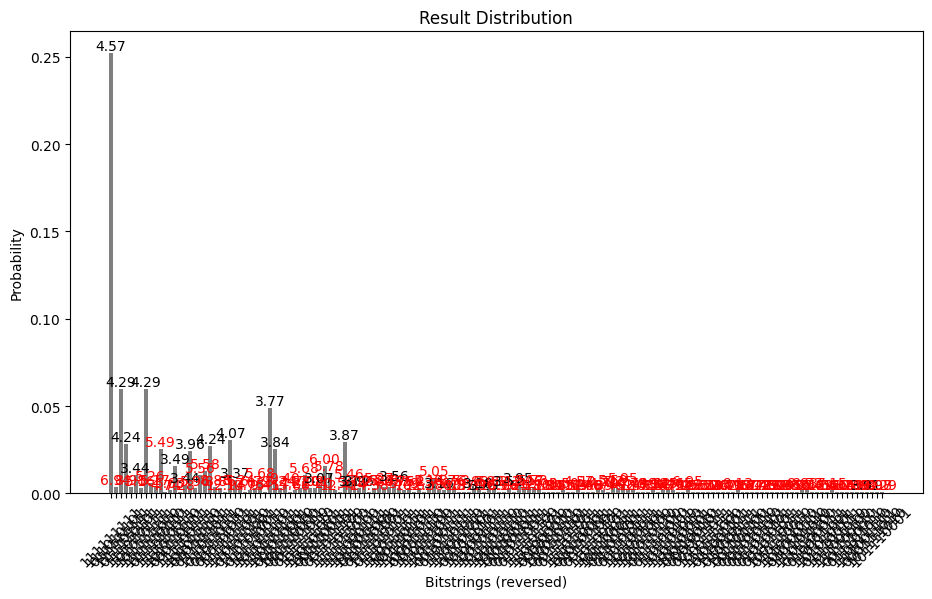

In [7]:
graph = graphs[1]
import threading
import time
import os
print("OMP_NUM_THREADS (from os.environ):", os.environ.get("OMP_NUM_THREADS", "not set"))
def monitor_cpu(stop_event):
    while not stop_event.is_set():
        usage = psutil.cpu_percent(interval=0.5,percpu=True)
        print(f"[CPU Monitor] CPU usage: {usage}%")
quantum = QAOArunner(graph=graph, 
                     backend_mode = 'noisy_sampling',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla',    
                     optimizer='COBYLA',
                     depth =2,
                     problem_type='minvertexcover',
                     warm_start=False,
                     amount_shots = 1000,
                     max_tol = 1e-2,#lower shots and tolerance for faster runs
                     hamming_dist = 2
                     )

quantum.build_circuit()
print(quantum.cost_hamiltonian)
print(f"CPU usage during simulation: {psutil.cpu_percent()}%")
def run_simulation():
    quantum.run()
#print(f'Total time: {quantum.time_elapsed} in which {np.sum(quantum.runtimes)/quantum.time_elapsed:.2f}% was spent inside the cost_func_estimator and {1 - np.sum(quantum.runtimes)/quantum.time_elapsed:.2f} inside optimizer and help functions.')
#removed timer statements from qaoa so above line does not work
stop_event = threading.Event()
monitor_thread = threading.Thread(target=monitor_cpu, args=(stop_event,))
monitor_thread.start()

print("🧪 Running simulation with live CPU monitoring...")
start = time.time()
run_simulation()
end = time.time()

stop_event.set()
monitor_thread.join()

print(f"⏱️ Simulation time: {end - start:.2f} sec")
print(quantum.solution)
print(quantum.hamming_string)
print(quantum.evaluate_solution())
print(quantum.fev)
print(quantum.final_params)
print(quantum.time_elapsed)
print('m',quantum.get_prob_measure_optimal())
quantum.print_bitstrings()

In [8]:
# Simulate a short run, then
print(f"CPU usage during simulation: {psutil.cpu_percent()}%")

CPU usage during simulation: 10.7%


In [9]:
print(quantum.circuit.count_ops())


OrderedDict([('sx', 458), ('rz', 298), ('cz', 247), ('measure', 9), ('barrier', 1)])


{'amount_shots': 1000,
 'backend': AerSimulator('aer_simulator_from(fake_marrakesh)'
             noise_model=<NoiseModel on ['id', 'reset', 'measure', 'cz', 'x', 'sx']>),
 'backend_mode': 'noisy_sampling',
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000017DF62D31F0>,
 'classical_objective_func_vals': [],
 'classical_objective_value': 3.0717011031740293,
 'classical_solution': [1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'cost_hamiltonian': SparsePauliOp(['IIIIIIIZI', 'IIIIIIIIZ', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIZIIZIII', 'ZIIIIZIII', 'ZIIIZIIII', 'IZIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[3.24810349+0.j, 3.69661881+0.j, 2.64929395+0.j, 1

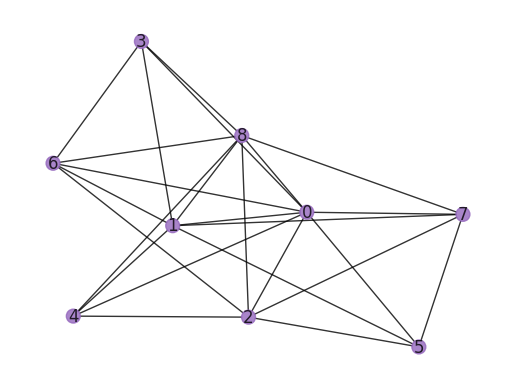

In [10]:
from pprint import pprint

pprint(quantum.__dict__)
quantum.plot_result()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_ibm_runtime import EstimatorV2 as Estimator
# Define the grid resolution
num_points = 100
gamma_vals = np.linspace(0, 4 * np.pi, num_points)
beta_vals = np.linspace(0,2* np.pi, num_points)
Gamma, Beta = np.meshgrid(gamma_vals, beta_vals)
Z = np.zeros_like(Gamma)



minvertexcover = False

quantum = QAOArunner(graph=graph, 
                     backend_mode='statevector',
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     depth = 1,
                     vertexcover=minvertexcover,
                     amount_shots = 1000,
                     max_tol = 1e-8,
                     lagrangian_multiplier=2
                     )
quantum.build_circuit()
estimator = Estimator(mode=quantum.backend)
estimator.options.default_shots = 5000
# Evaluate cost function at each grid point



for i in tqdm(range(Gamma.shape[0]), desc="Evaluating energy landscape"):
    for j in range(Gamma.shape[1]):
        params = np.array([Gamma[i, j], Beta[i, j]])  # Format your params as needed
        Z[i, j] = quantum.cost_func_estimator(params, quantum.circuit, quantum.cost_hamiltonian,estimator)

# Plot the energy landscape
plt.figure(figsize=(8, 6))
cp = plt.contourf(Gamma, Beta, Z, levels=50)
plt.colorbar(cp, label='Energy')
plt.title("Energy Landscape over [γ, β]")
plt.xlabel("Gamma (γ)")
plt.ylabel("Beta (β)")
plt.show()


TypeError: QAOArunner.__init__() got an unexpected keyword argument 'vertexcover'

In [ ]:
import pandas as pd

# Save Z as a CSV file
df_z = pd.DataFrame({'x': Gamma.ravel(), 'y': Beta.ravel(), 'z': Z.ravel()})
df_z.columns = ['x', 'y', 'z']
df_z.to_csv('percentage_measure_optimal_erdos_renyi_5_2_MaxCut.csv', index=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

strin = 'MinVertexCover' if minvertexcover else 'MaxCut'

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=Gamma, y=Beta, colorscale='Viridis')])
fig.update_layout(
    title=f"Percent chance of sampling optimal solution given [γ, β] for Erdos Renyi graph size 5, high prob of edges, for {strin}",
    scene=dict(
        xaxis_title="Gamma (γ)",
        yaxis_title="Beta (β)",
        zaxis_title="Energy"
    )
)
fig.show()

